In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

In [7]:
import gensim
import numpy as np

The dataset contains only two columns, the published date, and the news heading.

For simplicity, I will be exploring the first __10000__ rows from this dataset. Since the headlines are sorted by publish_date it is actually 2 months from February/19/2003 until April/07/2003.

Ok, I think we are ready to start our data exploration!

In [2]:
news= pd.read_csv('D:/data_science/data/news_data/abcnews-date-text.csv',nrows=10000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


# Analyzing text statistics

## Text statistics visualizations are simple but very insightful techniques.

They include:

1. word frequency analysis,
2. sentence length analysis,
3. average word length analysis

Those really help __explore the fundamental characteristics__ of the text data.

To do so, we will be mostly using __histograms__ (continuous data) and __bar charts__ (categorical data).

First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

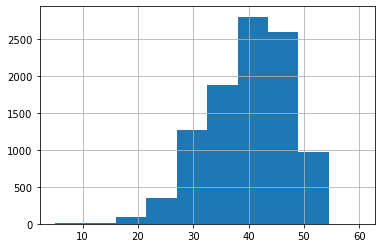

In [3]:
news['headline_text'].str.len().hist()

Code Snippet that Generates this Chart

The histogram shows that news headlines range from 10 to 70 characters and generally, it is between 25 to 55 characters.

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

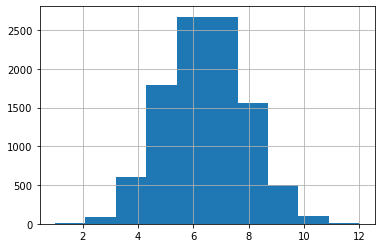

In [5]:
news['headline_text'].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in news headlines ranges from 2 to 12 and mostly falls between 5 to 7 words.

Up next, let’s check the average word length in each sentence.

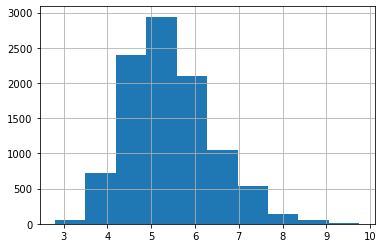

In [8]:
news['headline_text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The average word length ranges between 3 to 9 with 5 being the most common length. Does it mean that people are using really short words in news headlines?
Let’s find out.

One reason why this may not be true is stopwords.
Stopwords are the words that are most commonly used in any language such as “the”,” a”,” an” etc.
As these words are probably small in length these words may have caused the above graph to be left-skewed.

Analyzing the amount and the types of stopwords can give us some good insights into the data.

To get the corpus containing stopwords you can use the __nltk__ library. 
Nltk contains stopwords from many languages. Since we are only dealing with English news I will filter the English stopwords from the corpus.

In [10]:
import nltk

In [17]:
from nltk.corpus import stopwords

In [18]:
stop=set(stopwords.words('english'))

In [19]:
corpus=[]
new= news['headline_text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [21]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

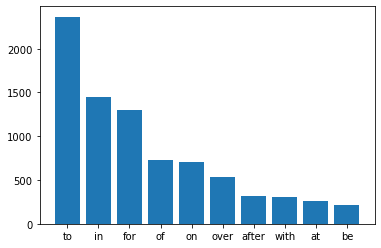

In [23]:
plot_top_stopwords_barchart(news['headline_text'])

We can evidently see that stopwords such as “to”,” in” and “for” dominate in news headlines.

So now we know which stopwords occur frequently in our text, let’s inspect which words other than these stopwords occur frequently.

We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples. This is a very useful function when we deal with word-level analysis in natural language processing.

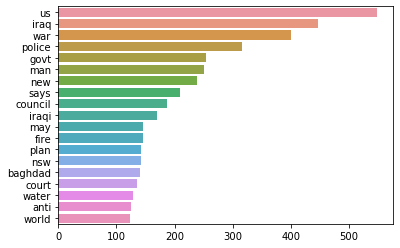

In [25]:
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

Wow! The “us”, “Iraq” and “war” dominate the headlines over the last 15 years.

Here ‘us’ could mean either the USA or us (you and me). us is not a stopword, but when we observe other words in the graph they are all related to the US – Iraq war and “us” here probably indicate the USA.

# Ngram exploration
Ngrams are simply contiguous sequences of n words. For example “riverbank”,” The three musketeers” etc.
If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

To implement n-grams we will use ngrams function from nltk.util. For example:

In [26]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

Now that we know how to create n-grams lets visualize them.

To build a representation of our vocabulary we will use __Countvectorizer__. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. It is available in sklearn.feature_engineering.text

So with all this, we will analyze the top bigrams in our news headlines.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

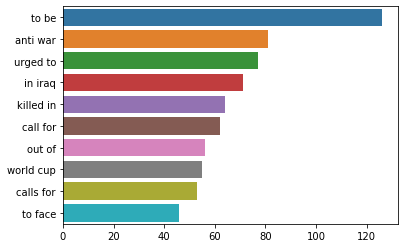

In [28]:
plot_top_ngrams_barchart(news['headline_text'],2)

We can observe that the bigrams such as ‘anti-war’, ’killed in’ that are related to war dominate the news headlines.

How about trigrams?

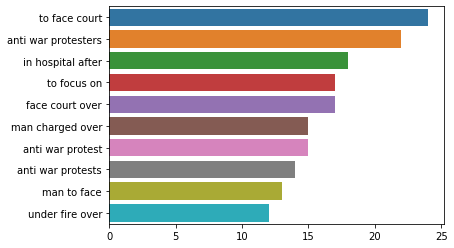

In [30]:
plot_top_ngrams_barchart(news['headline_text'],3)

We can see that many of these trigrams are some combinations of “to face court” and “anti war protest”. It means that we should put some effort into data cleaning and see if we were able to combine those synonym terms into one clean token.

## Topic Modeling exploration with pyLDAvis
Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.

But before getting into topic modeling we have to pre-process our data a little. We will:

1. tokenize: the process by which sentences are converted to a list of tokens or words.
2. remove stopwords
3. lemmatize: reduces the inflectional forms of each word into a common base or root.
4. convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

With NLTK you can tokenize and lemmatize easily:

In [31]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zshnh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zshnh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [35]:
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

In [36]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(news)

Now, let’s create the bag of words model using gensim

In [37]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [38]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.011*"baghdad" + 0.007*"face" + 0.007*"world" + 0.007*"cup" + 0.005*"force" + 0.005*"rain" + 0.004*"court" + 0.004*"council" + 0.004*"get" + 0.004*"charge"'),
 (1,
  '0.027*"war" + 0.023*"iraq" + 0.012*"say" + 0.008*"anti" + 0.007*"iraqi" + 0.006*"sars" + 0.006*"hit" + 0.006*"claim" + 0.005*"protest" + 0.005*"troop"'),
 (2,
  '0.007*"win" + 0.007*"attack" + 0.006*"man" + 0.006*"call" + 0.005*"iraq" + 0.005*"bomb" + 0.004*"baghdad" + 0.004*"fire" + 0.004*"may" + 0.004*"suicide"'),
 (3,
  '0.016*"police" + 0.009*"death" + 0.009*"plan" + 0.007*"man" + 0.007*"crash" + 0.006*"govt" + 0.006*"council" + 0.006*"nsw" + 0.006*"woman" + 0.005*"new"')]

The topic __0__ indicates something related to the __Iraq war and police__ . Topic __3__ shows the involvement of __Australia__ in the Iraq war.

You can print all the topics and try to make sense of them but there are tools that can help you run this data exploration more efficiently. One such tool is pyLDAvis which visualizes the results of LDA interactively.

In [39]:
import pyLDAvis.gensim

In [40]:
def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [41]:
lda_model, bow_corpus, dic = get_lda_objects(news['headline_text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zshnh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
lda_model.show_topics()

[(0,
  '0.012*"council" + 0.007*"get" + 0.007*"call" + 0.006*"govt" + 0.006*"new" + 0.005*"boost" + 0.005*"plan" + 0.004*"act" + 0.004*"help" + 0.004*"water"'),
 (1,
  '0.028*"iraq" + 0.017*"war" + 0.009*"say" + 0.009*"baghdad" + 0.009*"iraqi" + 0.007*"force" + 0.006*"win" + 0.006*"world" + 0.005*"cup" + 0.005*"hospital"'),
 (2,
  '0.011*"war" + 0.007*"govt" + 0.006*"troop" + 0.006*"anti" + 0.006*"plan" + 0.006*"nsw" + 0.006*"baghdad" + 0.005*"report" + 0.004*"car" + 0.004*"man"'),
 (3,
  '0.018*"police" + 0.012*"man" + 0.008*"death" + 0.006*"court" + 0.006*"charge" + 0.006*"charged" + 0.006*"face" + 0.005*"sars" + 0.005*"murder" + 0.005*"probe"')]

In [43]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.184313  0.017117       1        1  26.548376
2     -0.015538 -0.026269       2        1  25.884998
0      0.093918 -0.147915       3        1  24.782864
3      0.105933  0.157067       4        1  22.783766, topic_info=         Term        Freq       Total Category  logprob  loglift
43       iraq  413.000000  413.000000  Default  30.0000  30.0000
49        war  380.000000  380.000000  Default  29.0000  29.0000
275    police  252.000000  252.000000  Default  28.0000  28.0000
42    council  167.000000  167.000000  Default  27.0000  27.0000
317       man  208.000000  208.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
300  minister   33.855598   66.930679   Topic4  -5.8384   0.7976
519    farmer   31.418526   58.561462   Topic4  -5.9131   0.8564
190      urge   31.163357   58.152187   Topic4  -5.9213   0.8553
188      govt   40.236561  216.631241   Topic4  -5.6657  -0.2043
437       new   37.626495  200.286255   Topic4  -5.7328  -0.1929

[296 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
749       4  0.967144  abattoir
1382      2  0.929954      accc
5         1  0.097432       act
5         3  0.893122       act
646       3  0.885279       afl
...     ...       ...       ...
414       3  0.229055     woman
414       4  0.250870     woman
4481      3  0.947305   working
488       1  0.751415     world
488       2  0.241195     world

[478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

1. On the left side, the area of each circle represents the importance of the topic relative to the corpus. As there are four topics, we have four circles.

2. The distance between the center of the circles indicates the similarity between the topics. Here you can see that the topic 3 and topic 4 overlap, this indicates that the topics are more similar.

3. On the right side, the histogram of each topic shows the top 30 relevant words. For example, in topic 1 the most relevant words are police, new, may, war, etc


So in our case, we can see a lot of words and topics associated with war in the news headlines.

## Wordcloud
Wordcloud is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

Creating wordcloud in python with is easy but we need the data in a form of a corpus. Luckily, I prepared it in the previous section.

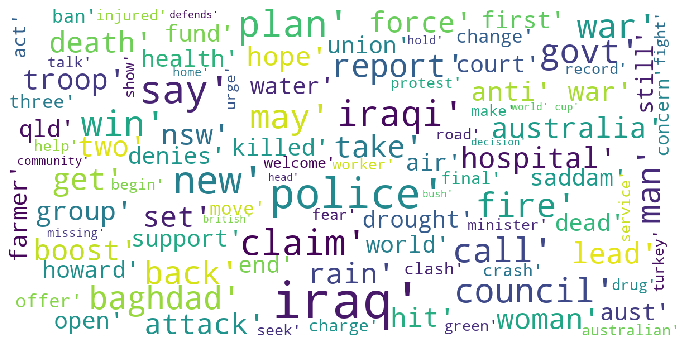

In [44]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

Again, you can see that the terms associated with the war are highlighted which indicates that these words occurred frequently in the news headlines.

There are many parameters that can be adjusted. Some of the most prominent ones are:

1. stopwords: The set of words that are blocked from appearing in the image.
2. max_words: Indicates the maximum number of words to be displayed.
3. max_font_size: maximum font size.


There are many more options to create beautiful word clouds. For more details, you can refer here.

## Sentiment analysis
Sentiment analysis is a very common natural language processing task in which we determine if the text is positive, negative or neutral. This is very useful for finding the sentiment associated with reviews, comments which can get us some valuable insights out of text data.

There are many projects that will help you do sentiment analysis in python. I personally like TextBlob and Vader Sentiment.

## Textblob
Textblob is a python library built on top of nltk. It has been around for some time and is very easy and convenient to use.

The sentiment function of TextBlob returns two properties:

<br>__polarity__: is a floating-point number that lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

<br>__subjectivity__: refers to how someone’s judgment is shaped by personal opinions and feelings. Subjectivity is represented as a floating-point value which lies in the range of [0,1].

In [45]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

TextBlob claims that the text “100 people killed in Iraq” is negative and is not an opinion or feeling but rather a factual statement. I think we can agree with TextBlob here.

Now that we know how to calculate those sentiment scores we can visualize them using a histogram and explore data even further.

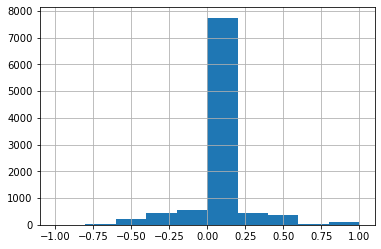

In [46]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['headline_text'].\
   apply(lambda x : polarity(x))
news['polarity_score'].hist()

You can see that the polarity mainly ranges between 0.00 and 0.20. This indicates that the majority of the news headlines are neutral.

Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

<BarContainer object of 3 artists>

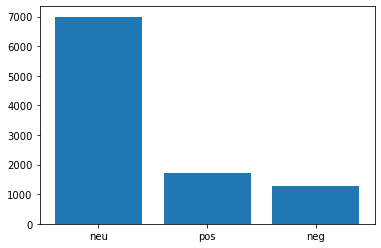

In [47]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].\
   map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

Yep, __70 %__ of news is __neutral__ with only __18%__ of __positive__ and __11%__ of __negative__.

Let’s take a look at __some of the positive and negative headlines.__

In [48]:
news[news['polarity']=='pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [49]:
news[news['polarity']=='neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

## Vader Sentiment Analysis

The next library we are going to discuss is VADER. Vader works better in detecting negative sentiment. It is very useful in the case of social media text sentiment analysis.

VADER or Valence Aware Dictionary and Sentiment Reasoner is a rule/lexicon-based, open-source sentiment analyzer pre-built library, protected under the MIT license.

VADER sentiment analysis class returns a dictionary that contains the probabilities of the text for being positive, negative and neutral. Then we can filter and choose the sentiment with most probability.

We will do the same analysis using VADER and check if there is much difference.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zshnh\AppData\Roaming\nltk_data...


<BarContainer object of 3 artists>

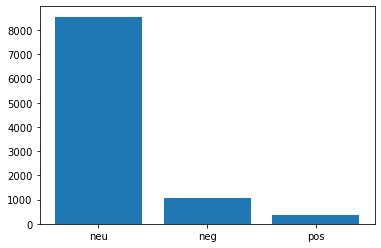

In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

Yep, there is a slight difference in distribution. Even more headlines are classified as neutral 85 % and the number of negative news headlines has increased (to 13 %).

## Named Entity Recognition
Named entity recognition is an information extraction method in which entities that are present in the text are classified into predefined entity types like “Person”,” Place”,” Organization”, etc. By using NER we can get great insights about the types of entities present in the given text dataset.

Let us consider an example of a news article.

There are three standard libraries to do Named Entity Recognition:

1. Standford NER
2. spaCy
3. NLTK

In this tutorial, I will use spaCy which is an open-source library for advanced natural language processing tasks. It is written in Cython and is known for its industrial applications. Besides NER, spaCy provides many other functionalities like pos tagging, word to vector transformation, etc.

There are three pre-trained models for English in spaCy. I will use en_core_web_sm for our task but you can try other models.

To use it we have to download it first:

In [52]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [53]:
doc=nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'),
 ('Iran', 'GPE'),
 ('Chabahar', 'PERSON'),
 ('Thursday', 'DATE')]

We can see that India and Iran are recognized as Geographical locations (GPE), Chabahar as Person and Thursday as Date.

We can also visualize the output using displacy module in spaCy.

In [54]:
from spacy import displacy

displacy.render(doc, style='ent')

This creates a very neat visualization of the sentence with the recognized entities where each entity type is marked in different colors.

Now that we know how to perform NER we can explore the data even further by doing a variety of visualizations on the named entities extracted from our dataset.

First, we will run the named entity recognition on our news headlines and store the entity types.

In [55]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['headline_text'].\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

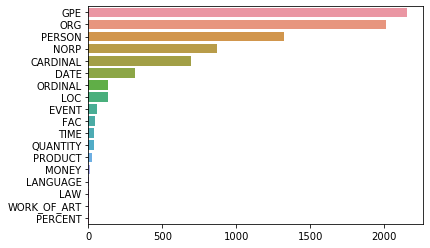

In [56]:
# Now, we can visualize the entity frequencies:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

Now we can see that the GPE and ORG dominate the news headlines followed by the PERSON entity.

We can also visualize the most common tokens per entity. Let’s check which places appear the most in news headlines.

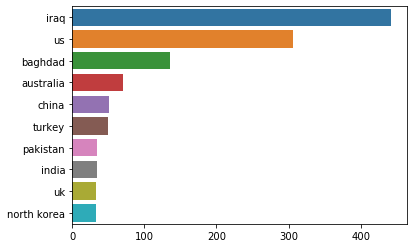

In [57]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=news['headline_text'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

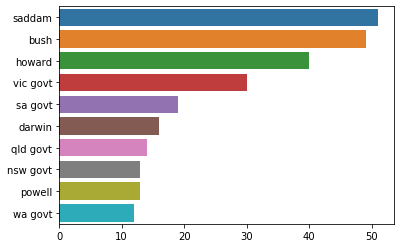

In [58]:
per=news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

Saddam Hussain and George Bush were the presidents of Iraq and the USA during wartime. Also, we can see that the model is far from perfect classifying “vic govt” or “nsw govt” as a person rather than a government agency.

## Exploration through Parts of Speach Tagging in python

Parts of speech (POS) tagging is a method that assigns part of speech labels to words in a sentence. There are eight main parts of speech:

1. Noun (NN)- Joseph, London, table, cat, teacher, pen, city
2. Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
3. Adjective(JJ)- beautiful, happy, sad, young, fun, three
4. Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow
5. Preposition (IN)- at, on, in, from, with, near, between, about, under
6. Conjunction (CC)- and, or, but, because, so, yet, unless, since, if
7. Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this
8. Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

This is not a straightforward task, as the same word may be used in different sentences in different contexts. However, once you do it, there are a lot of helpful visualizations that you can create that can give you additional insights into your dataset.

__I will use the nltk to do the parts of speech tagging__ but there are other libraries that do a good job (spacy, textblob).

Let’s look at an example.

In [60]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zshnh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [61]:
sentence="The greatest comeback stories in 2019"
tokens=word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

You can also visualize the sentence parts of speech and its dependency graph with spacy.displacy module.

In [63]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

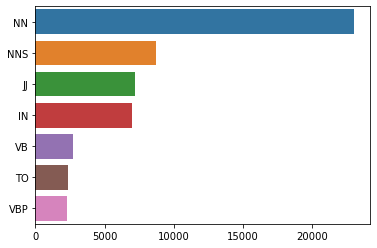

In [64]:
#POS Tagging on Dataset

def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags=news['headline_text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

We can clearly see that the noun (NN) dominates in news headlines followed by the adjective (JJ). This is typical for news articles while for artistic forms higher adjective(ADJ) frequency could happen quite a lot.

You can dig deeper into this by investigating which singular noun occur most commonly in news headlines. Let us find out.

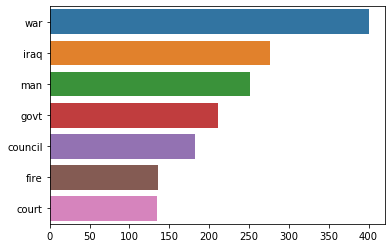

In [65]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words=news['headline_text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

Nouns such as “war”, “iraq”, “man” dominate in the news headlines. 
<br>You can visualize and examine other parts of speech using the above function.

## Exploring through text complexity
It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. Do we need a college degree to understand the message or a first-grader can clearly see what the point is?

You can actually put a number called readability index on a document or text. Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.

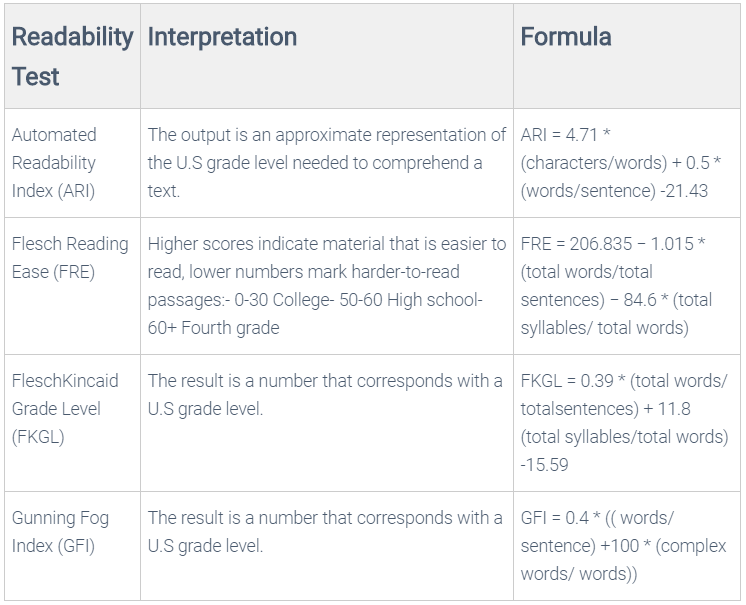

Textstat is a cool Python library that provides an implementation of all these text statistics calculation methods. Let’s use Textstat to implement Flesch Reading Ease index.

Now, you can plot a histogram of the scores and visualize the output.

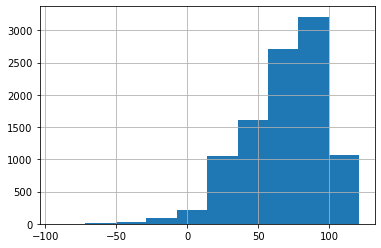

In [76]:
from textstat import flesch_reading_ease

news['headline_text'].\
   apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5.

In [77]:
x=[i for i in range(len(reading)) if reading[i]<5]
news.iloc[x]['headline_text'].head()

NameError: name 'reading' is not defined

## Final Thoughts
In this notebook, we discussed and implemented various exploratory data analysis methods for text data. 

Some common, some lesser-known but all of them could be a great addition to your data exploration toolkit.